# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-IMA205-YOUR-SURNAME.ipynb') with your answers to the Site pédagogique before the 18th of March 2020 (23h59).

Please complete the code where you see XXXXXXXXXXXX and answer the questions.

We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1x* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [0]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [0]:
# Choose Atlas (here AAL2)
X=T1AAL2
labels=ROIlabelsAAL2
atlas='./AtlasAAL2.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

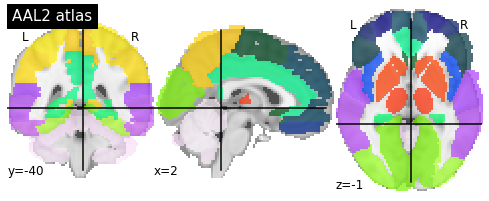

In [0]:
plotting.plot_roi(atlas, title="AAL2 atlas")
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to scale the features so that each feature will have average equal to 0 and unit variance and create a training and test set.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_=scaler.transform(X)

# Create training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, np.ravel(y), test_size=0.33, random_state=26)


Then, we can fit a Decision tree, with the default setting, using the following code:

In [0]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Fitting Decision Trees with maximum depth equal to 4 (to keep the output simple)
Tree = DecisionTreeClassifier(max_depth=4)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 0.8727634194831014
Score in the test set is 0.7630522088353414


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 1 and 10) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'. **Question:** What is the best value ? What happens if you split differently your data ? 

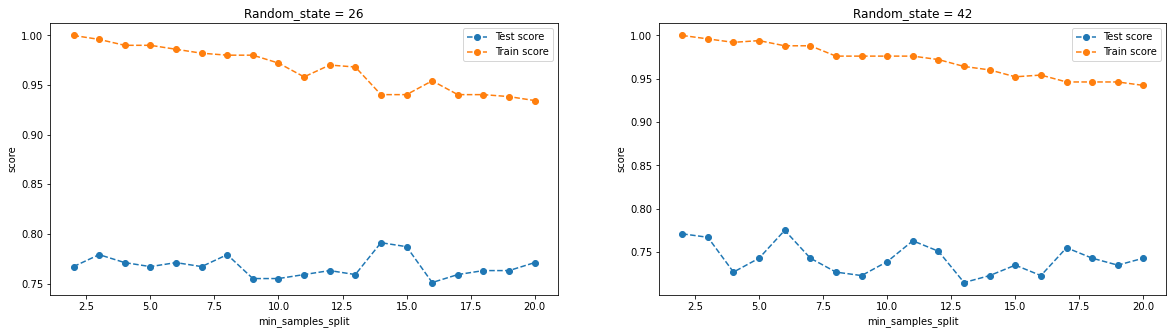

In [0]:
# 'min_samples_split'
X_train, X_test, y_train, y_test = train_test_split(X_, np.ravel(y), test_size=0.33, random_state=26)
ab=np.linspace(2,20,19)
TTest=[]
TTrain=[]
for i in range(2,21):
  Tree = DecisionTreeClassifier(min_samples_split=i)
  Tree.fit(X_train,y_train)
  TTrain.append(Tree.score(X_train,y_train))
  TTest.append(Tree.score(X_test,y_test))

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(ab,TTest,linestyle='--',marker='o',label='Test score')
plt.plot(ab,TTrain,linestyle='--',marker='o',label='Train score')
plt.xlabel("min_samples_split")
plt.ylabel("score")
plt.title("Random_state = 26")
plt.legend()


#On teste une autre distribution :
X_train, X_test, y_train, y_test = train_test_split(X_, np.ravel(y), test_size=0.33, random_state=42)
TTest=[]
TTrain=[]
for i in range(2,21):
  Tree = DecisionTreeClassifier(min_samples_split=i)
  Tree.fit(X_train,y_train)
  TTrain.append(Tree.score(X_train,y_train))
  TTest.append(Tree.score(X_test,y_test))

plt.subplot(122)
plt.plot(ab,TTest,linestyle='--',marker='o',label='Test score')
plt.plot(ab,TTrain,linestyle='--',marker='o',label='Train score')
plt.xlabel("min_samples_split")
plt.ylabel("score")
plt.title("Random_state = 42")
plt.legend()
plt.show()

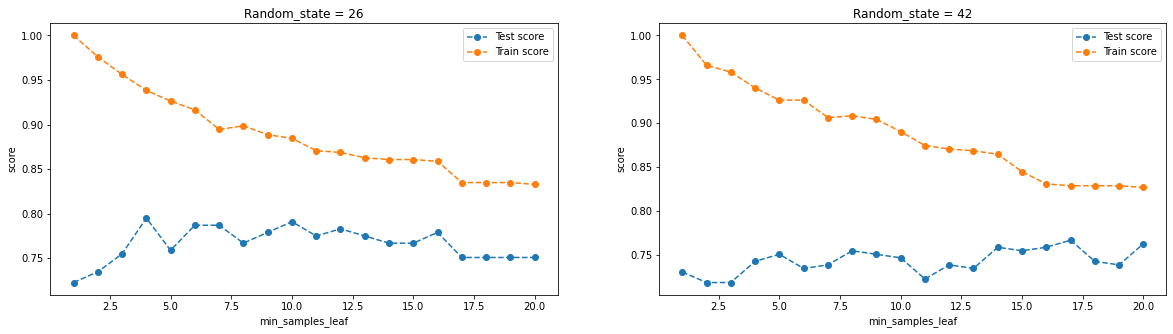

In [0]:
# 'min_samples_leaf'
X_train, X_test, y_train, y_test = train_test_split(X_, np.ravel(y), test_size=0.33, random_state=26)
ab=np.linspace(1,20,20)
TTest=[]
TTrain=[]
for i in range(1,21):
  Tree = DecisionTreeClassifier(min_samples_leaf=i)
  Tree.fit(X_train,y_train)
  TTrain.append(Tree.score(X_train,y_train))
  TTest.append(Tree.score(X_test,y_test))

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(ab,TTest,linestyle='--',marker='o',label='Test score')
plt.plot(ab,TTrain,linestyle='--',marker='o',label='Train score')
plt.xlabel("min_samples_leaf")
plt.ylabel("score")
plt.title("Random_state = 26")
plt.legend()

#On teste différents splits
X_train, X_test, y_train, y_test = train_test_split(X_, np.ravel(y), test_size=0.33, random_state=42)
TTest=[]
TTrain=[]
for i in range(1,21):
  Tree = DecisionTreeClassifier(min_samples_leaf=i)
  Tree.fit(X_train,y_train)
  TTrain.append(Tree.score(X_train,y_train))
  TTest.append(Tree.score(X_test,y_test))

plt.subplot(122)
plt.plot(ab,TTest,linestyle='--',marker='o',label='Test score')
plt.plot(ab,TTrain,linestyle='--',marker='o',label='Train score')
plt.xlabel("min_samples_leaf")
plt.ylabel("score")
plt.title("Random_state = 42")
plt.legend()
plt.show()


--- 
__Reponse__:

Pour le set de train les meilleurs résultats sont obtenus pour min_samples_split = 2 ou min_samples_leaf=1, en effet, si l'on choisit ces paramètres certaines feuilles de l'arbre ne contiennent qu'une donnée. Les scores du train est alors de 1, mais les scores du train sont relativements bas. En effet, il faut choisir des paramètre suffisament grands pour ne pas faire de l'overfitting.  

Les résultats du train diminuent quand les paramètres augmentent, tandis que ceux du test sont meilleurs si les paramètres ne sont pas minimaux.

Pour la distribution random_state = 26, les meilleurs paramètres sont : 
- min_sample_split = 14

- min_sample_leaf = 4

Pour la distribution random_state = 42, les meilleurs paramètres sont : 
- min_sample_split = 6

- min_sample_leaf = 17

Les résultats dépendent beaucoup de la distribution des données entre test et data, cependant il semblent que les meilleurs paramètres soient de l'ordre de grandeur de la dizaine. 

---

Try to add Gaussian noise to the data (using for instance zero mean and 0.5 for the std) and, using the best hyperparameters found before, look at the test score. Repeat this process several times (at least 100 times) and compare the results with the score obtained without adding noise. **Question:** Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)*

Train score moyen sur 100 itérations = 0.910596421471173
Test score moyen sur 100 itérations = 0.6692369477911647


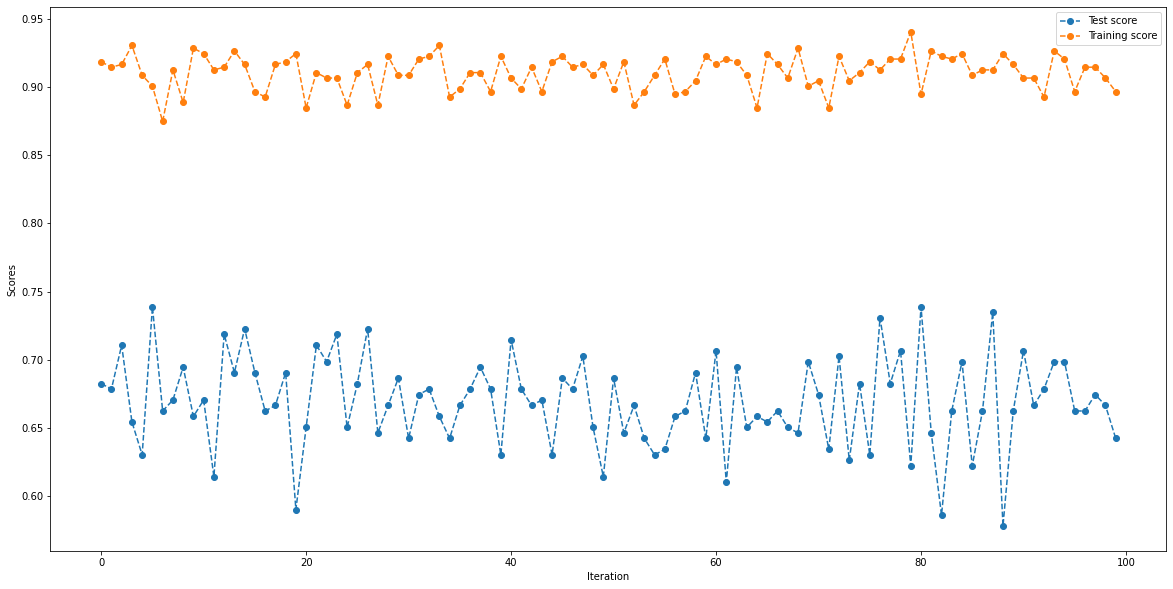

In [0]:
from numpy import random

TTest=[]
TTrain=[]

X_train, X_test, y_train, y_test = train_test_split(X_, np.ravel(y), test_size=0.33, random_state=26)

mean=[0 for i in range(M)]
cov=0.5*np.identity(M)

for i in range(100):
  X_train_noise=[]
  X_test_noise=[]

  for x in X_train:
    new_x=x+random.multivariate_normal(mean,cov)
    X_train_noise.append(new_x)

  for x in X_test:
    new_x=x+random.multivariate_normal(mean,cov)
    X_test_noise.append(new_x)

  Tree = DecisionTreeClassifier(min_samples_split=14,min_samples_leaf=4)
  Tree.fit(X_train_noise,y_train)
  # Score in the training set
  TTrain.append(Tree.score(X_train_noise,y_train))
  # Score in the test set
  TTest.append(Tree.score(X_test_noise,y_test))

print("Train score moyen sur 100 itérations = "+str(np.mean(TTrain)))
print("Test score moyen sur 100 itérations = "+str(np.mean(TTest)))
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,100),TTest,linestyle='--',marker='o',label='Test score')
plt.plot(np.arange(0,100),TTrain,linestyle='--',marker='o',label="Training score")
plt.xlabel("Iteration")
plt.ylabel("Scores")
plt.legend()
plt.show()

---
__Réponse :__
Le score du set de test et du test de train varie à chaque itération et la moyenne sur 100 itérations est particulièrement basse, les résultats ne sont donc pas stable au bruit. 

---


To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

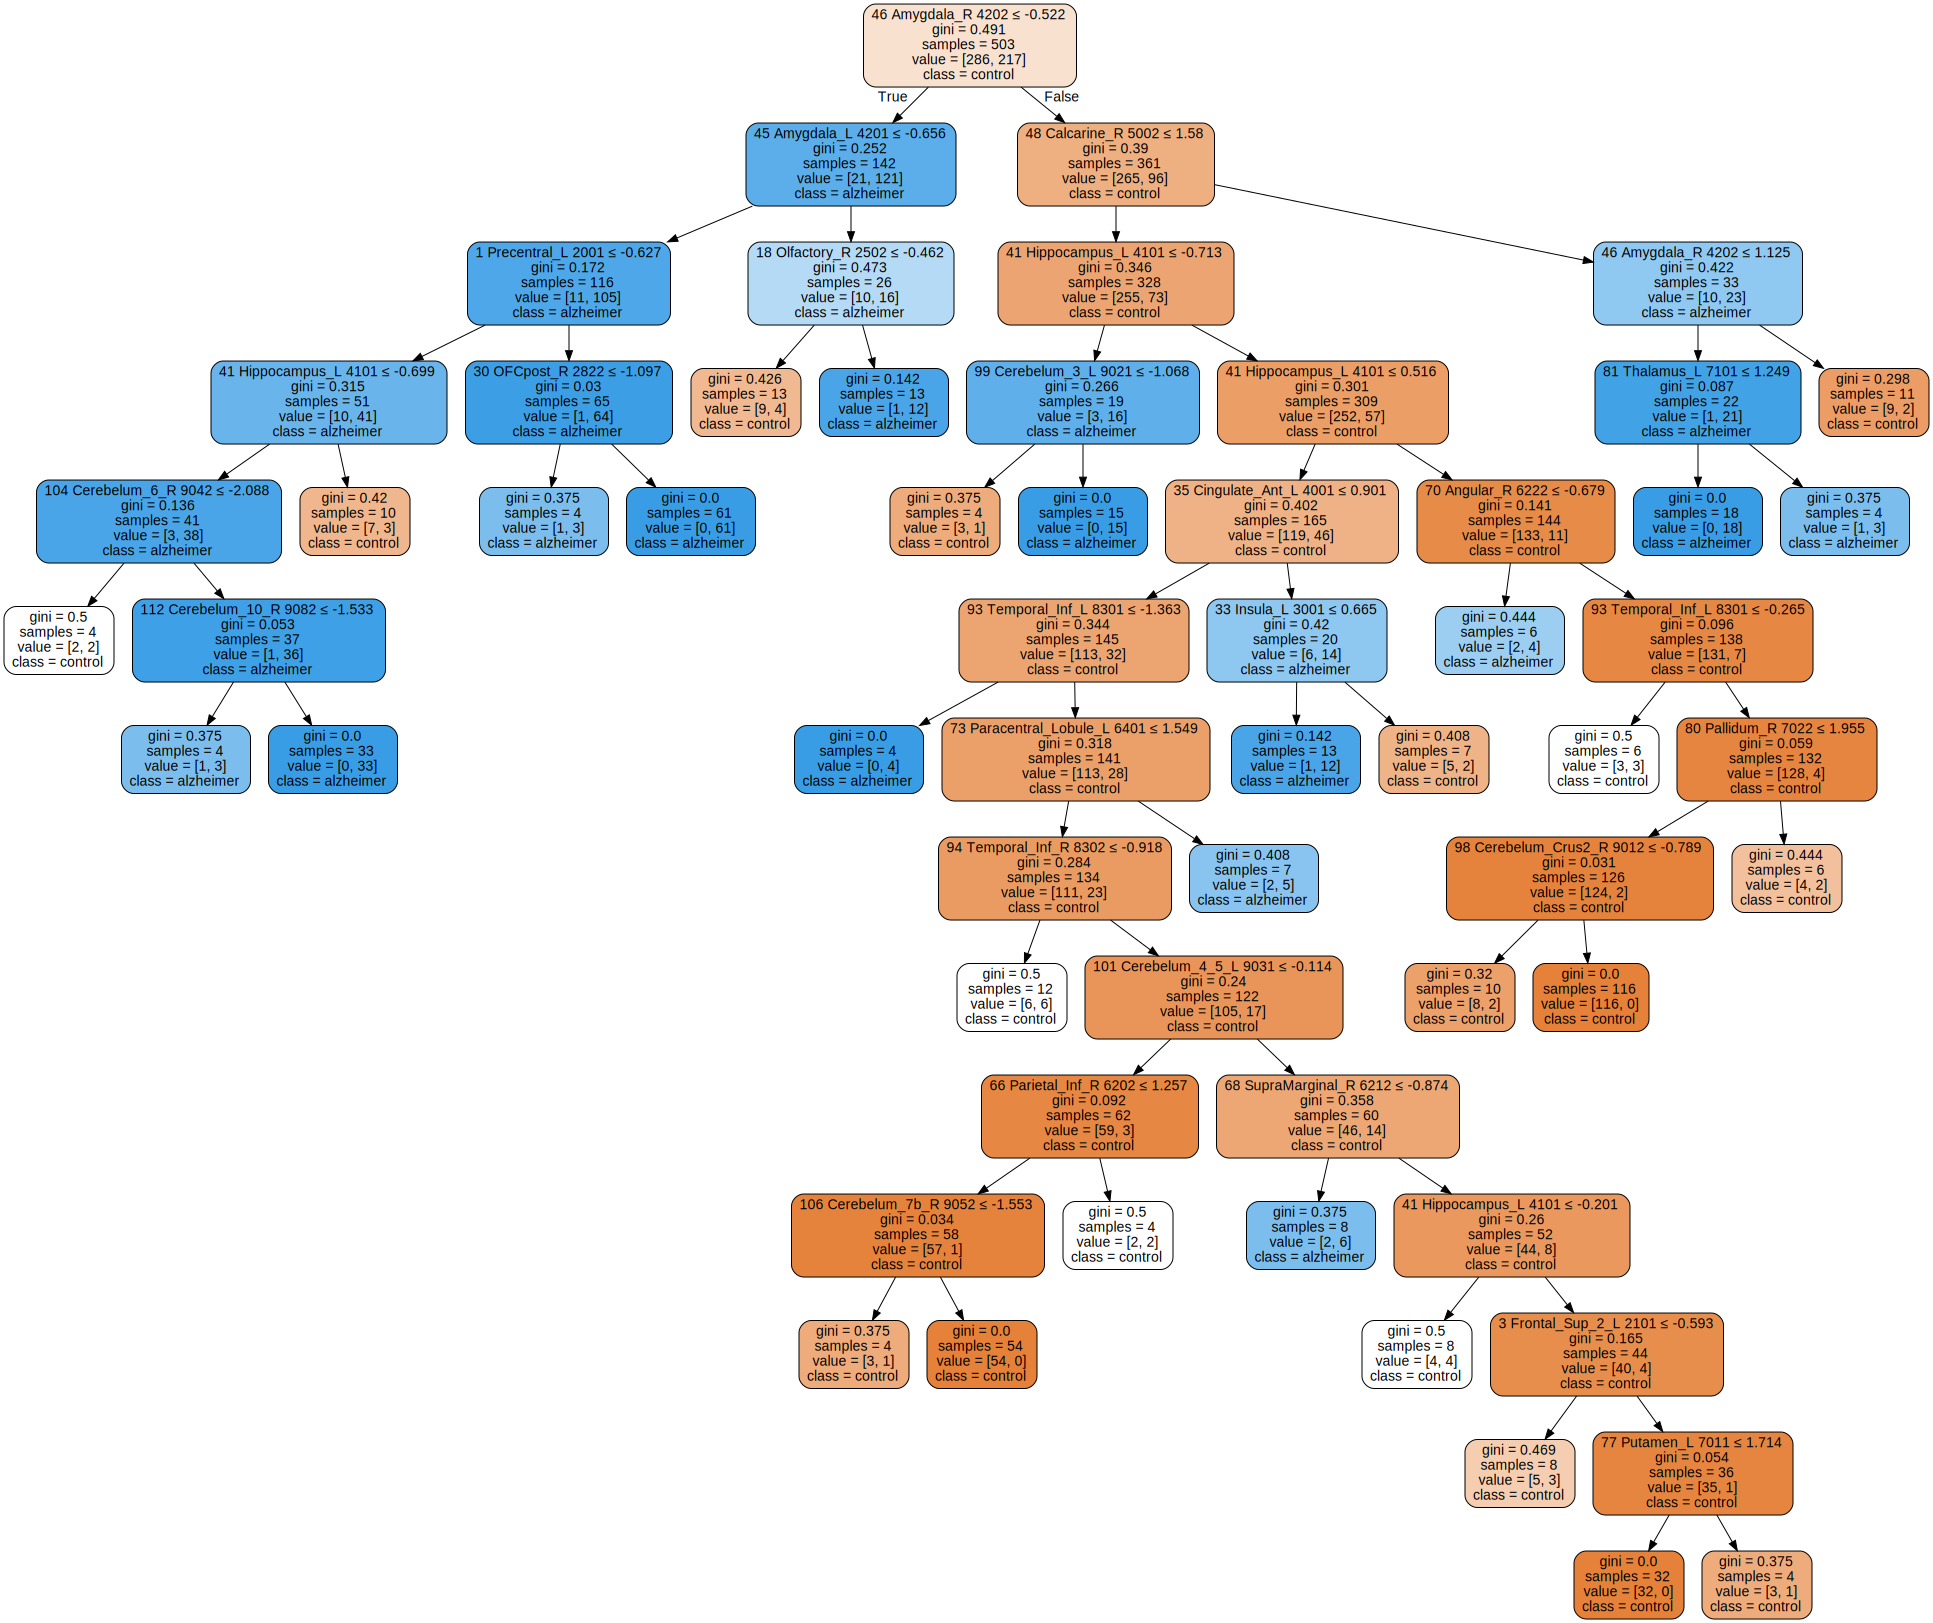

In [0]:
import graphviz 

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data. **Question:** Is it the same ? You can try several times, for different levels of noise. Comment the results.

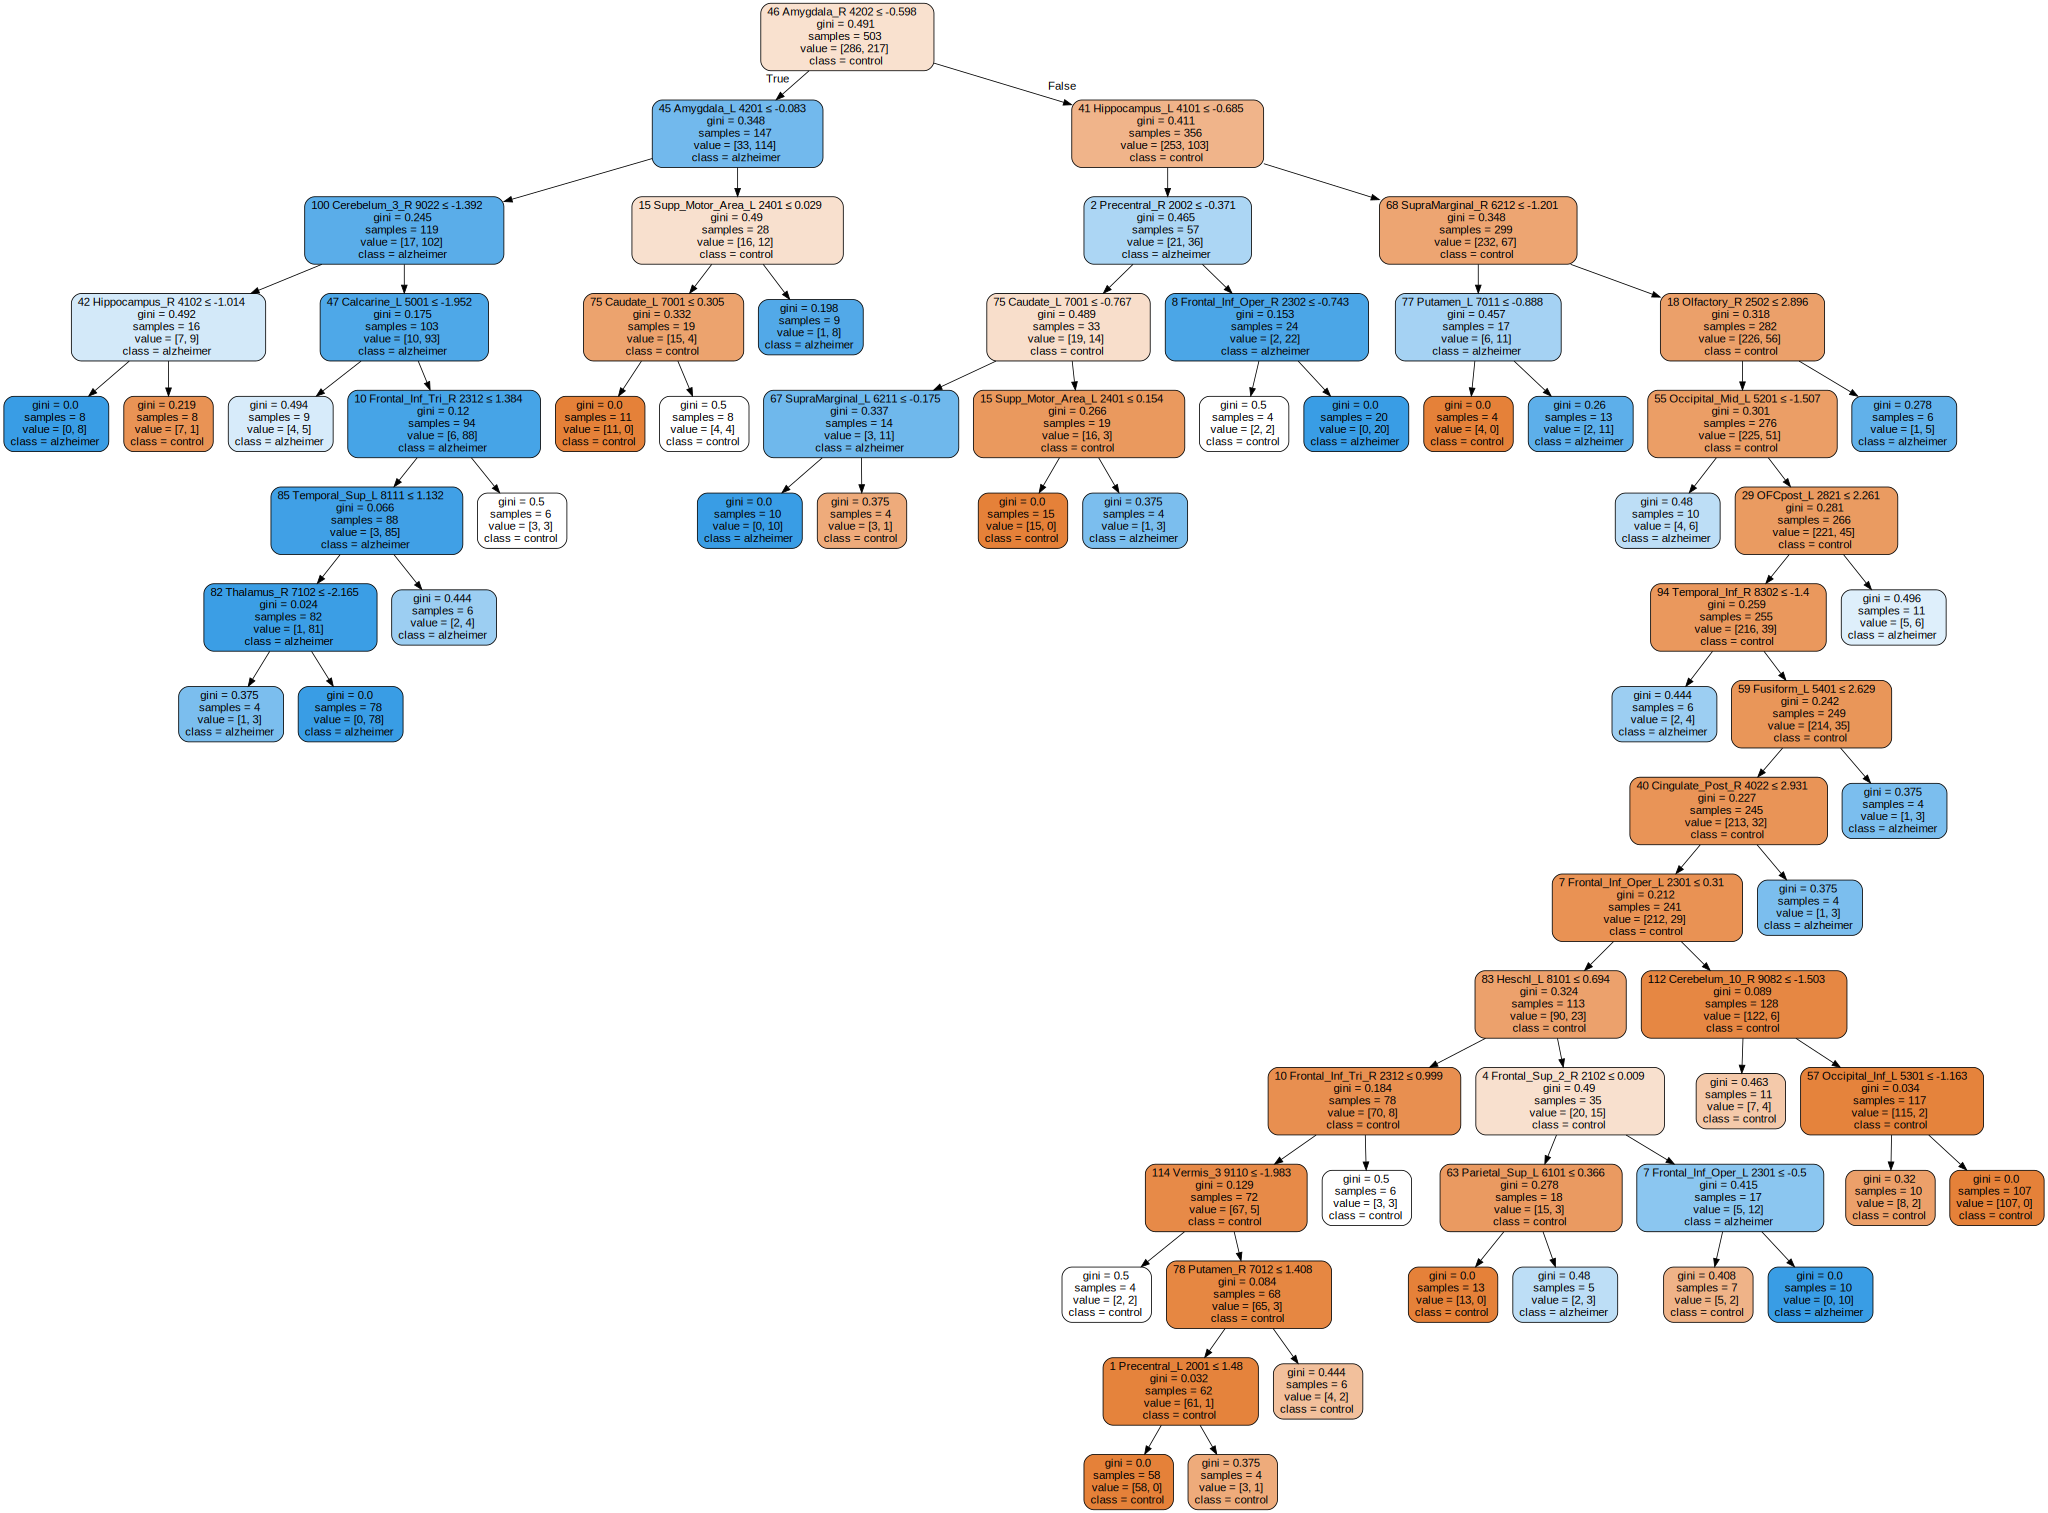

In [0]:
#Withe the same noise

Tree.fit(X_train_noise,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

---
__Reponse :__
Les résultats sont très différents avec du bruit, et les hyperplans séparateurs ne sont pas sélectionnés dans le même ordre. Dès la deuxième couche de l'arbre on observe des changements.
La racine ne change pas dans ce cas, mais peut changer si on augmente le bruit.
Si l'on diminue le bruit, le début de l'arbre reste pareil et seul les feuilles changent. 
Ainsi cette méthode n'est pas robuste au bruit.

---

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. **Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

In [0]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1),len(grid_param_2))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(20,15))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[:,idx], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores, random_state", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

Best Score: 0.7753024282560707
Best params: {'min_samples_leaf': 12, 'min_samples_split': 12}


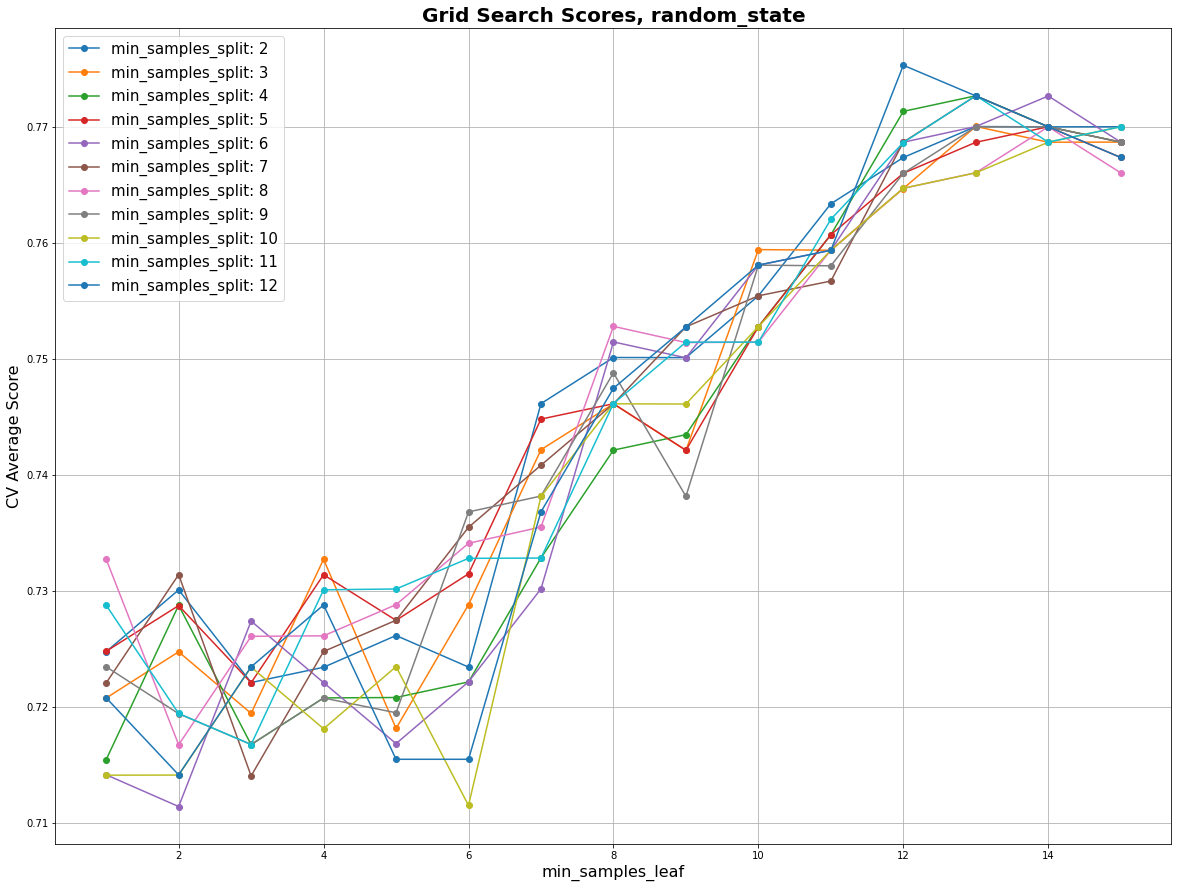

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X_, np.ravel(y), test_size=0.33, random_state=26)

p_grid_tree = {'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12],
              'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], }

Tree = DecisionTreeClassifier()

# Nested CV with parameter optimization
grid = GridSearchCV(estimator=Tree, param_grid=p_grid_tree,cv=5,refit=True)
grid.fit(X_,y)
# Calling Method 
plot_grid_search(grid.cv_results_,  p_grid_tree['min_samples_leaf'],p_grid_tree['min_samples_split'], 'min_samples_leaf','min_samples_split')
print("Best Score: {}".format(grid.best_score_))
print("Best params: {}".format(grid.cv_results_['params'][grid.best_index_] ))

Quand on utilise la cross validation, on obtient des résultats très différents, min_samples_leaf était à 4 et min_split autour de 14 (random_state = 26). En effet, cette fois les deux paramètres sont testés simultanéments. Le résultats dépendent encore beaucoup de comment sont séparés les sets de données, c'est pourquoi le résultat de cross-validation change si on change la distribution.


Il faut min_sample_split > 2 x min_sample_leaf pour que le choix du paramètre min_sample_split ai un effet. 

En utilisant uniquement les données de Train, regardons si nous trouvons les mêmes parmètres que tout à l'heure. 

In [0]:
#fit the classifier
grid_train = GridSearchCV(estimator=Tree, cv=3, param_grid=p_grid_tree,refit=True)
grid_train.fit(X_train, y_train)
print("Best Score: {}".format(grid_train.best_score_))
print("Best params: {}".format(grid_train.best_params_))
test_accuracy = grid_train.score(X_test, y_test)
print("Prediction Score : {}".format(test_accuracy))

Best Score: 0.7655284668757724
Best params: {'min_samples_leaf': 15, 'min_samples_split': 3}
Prediction Score : 0.7710843373493976


---
__Reponse :__ 
On ne trouve pas les mêmes paramètres optimaux, même en utilisant la même répartition entre X_train et X_test (random_state = 26). 

---

Using the optimal hyperparameers, plot again the decision tree using the *graphviz* library. **Question:** Is it the same ? Do you see ROIs that are always present nearby the root of the trees ? Comment the results.

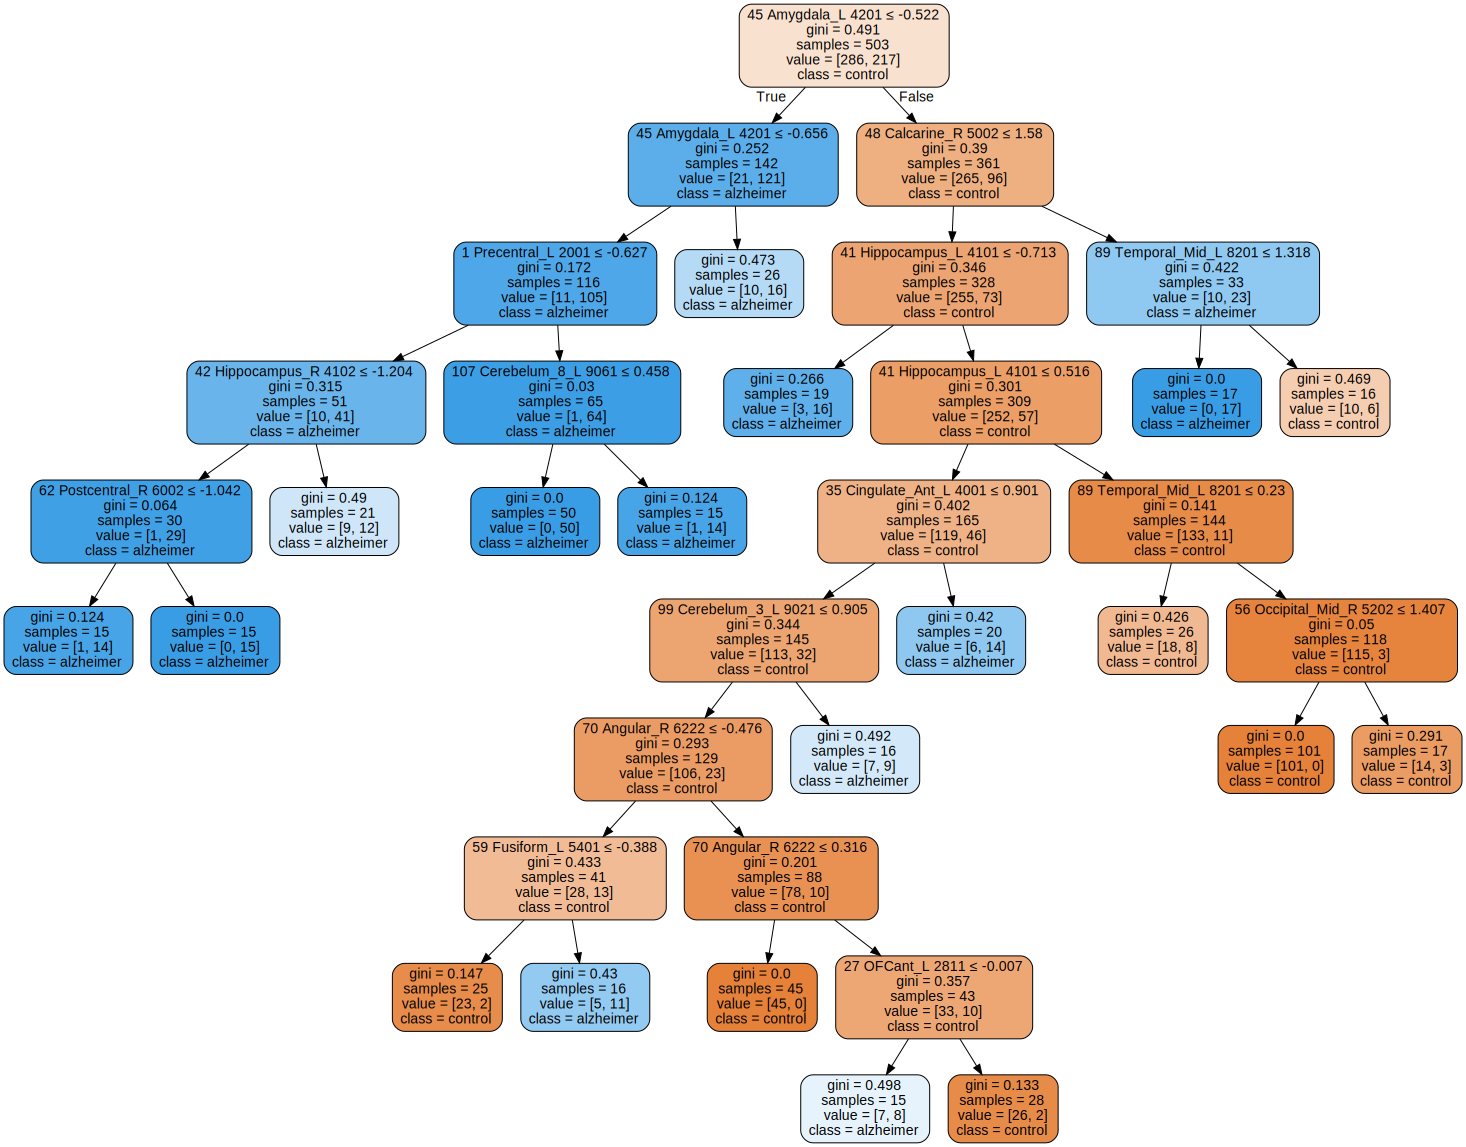

In [0]:
Tree = DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=15)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

---
__Réponse :__
Non, l'arbre est encore différent des deux derniers, la racine change notamment,cependant on remarque que certains ROI sont souvent proches de la racine, tels que 45 Amygdala L, 46 Amygdala R, 41 Hippocampus L ou 42 Hippocampus R. 

---

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. **Question:** What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

In [0]:
from sklearn.ensemble import BaggingClassifier

Tree = DecisionTreeClassifier(criterion="gini",min_samples_leaf=4,min_samples_split=8, random_state=26)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging.fit(X_train, y_train)
print("Best Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging score :",grid_bagging.score(X_test,y_test))

Best Score: 0.7893267326732674
Best params: {'n_estimators': 10}
Bagging score : 0.8192771084337349


In [0]:
# Noisy version 

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging.fit(X_train_noise, y_train)
print("Best Score (training) : {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging score (test) :",grid_bagging.score(X_test_noise,y_test))

Best Score (training) : 0.7375643564356437
Best params: {'n_estimators': 20}
Bagging score (test) : 0.7349397590361446


---
__Réponse : __
Le nombre de paramètres choisis sont raltivement proches avec ou sans bruit, ce modèle semble bien plus résistant au bruit. De plus les test_scores sont proches ou supérieurs au train_score, ce qui assure que nous n'avons pas d'over-fitting. 

---

The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [0]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="gini", random_state=26)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Score: 0.8012673267326733
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 15}


**Question:** Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

In [0]:
#Without noise

RF=RandomForestClassifier(criterion="gini", random_state=26,max_features='sqrt',min_samples_leaf=6,n_estimators=15)
RF.fit(X_train, y_train)

print("Training score without noise :",RF.score(X_train,y_train))
print("Test score without noise :",RF.score(X_test,y_test))


Training score without noise : 0.9264413518886679
Test score without noise : 0.8393574297188755


In [0]:
#Noisy version

RF.fit(X_train_noise, y_train)

print("Training score with noise :",RF.score(X_train_noise,y_train))
print("Test score with noise :",RF.score(X_test_noise,y_test))

Training score with noise : 0.9383697813121272
Test score with noise : 0.7550200803212851


---
__Réponse :__
Il semble que la méthode de Random Forest soit beaucoup plus sujette à l'over-fitting, elle est plus sensible au bruit que Bagging, mais moins que les decisions tree. 

---

We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 44 representing 45 Amygdala_L 4201
 (0.137388)
2. feature 45 representing 46 Amygdala_R 4202
 (0.075774)
3. feature 41 representing 42 Hippocampus_R 4102
 (0.056423)
4. feature 43 representing 44 ParaHippocampal_R 4112
 (0.053900)
5. feature 89 representing 90 Temporal_Mid_R 8202
 (0.045248)
6. feature 93 representing 94 Temporal_Inf_R 8302
 (0.036032)
7. feature 40 representing 41 Hippocampus_L 4101
 (0.035876)
8. feature 88 representing 89 Temporal_Mid_L 8201
 (0.024939)
9. feature 92 representing 93 Temporal_Inf_L 8301
 (0.021675)
10. feature 90 representing 91 Temporal_Pole_Mid_L 8211
 (0.017383)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


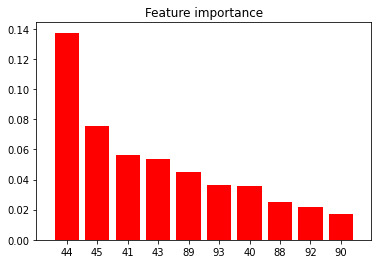

In [0]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=26)
RF.fit(X_,y)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])

plt.xlim([-1, 10])
plt.show()

**Question:** Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

---
__Réponse :__
Il semble que les features les plus importants soient, Amygdala L 4201, R 4202 et HIppocampus L 4102. Nous nous attendions, vus les arbres précédents, à ce que les amygdales et l'hippocampe soient des ROIs importants.

Dans les papier de recherche, on peut lire que la maladie provoque une atrophie de certaines zones du cerveau, particulièrement au niveau de l'hippocampus, mais aussi aux niveau du temporal et des amygdales. 

Dans NeuroImage, on peut lire que : 
 "This neurodegeneration process is more severe in certain parts of the brain, such as the right and left hippocampus [...]."

"Among recent studies, Tang et al. (2016) used volumetric, shape, and diﬀusion features of the hippocampus and amygdala for AD classiﬁcation."

Dan le papier de la National Institut of Health, on trouve que :
"Rates of change in several structural measures, including whole-brain,entorhinal cortex, hippocampus, and temporal lobe volumes, [...] correlate closely with changes in cognitive performance, supporting their validity as markers of disease progression."

Nos résultats concordent avec la littérature médicale, nos résultats semblent donc censés.

---

We can also inspect the data using only pairs of the most important features

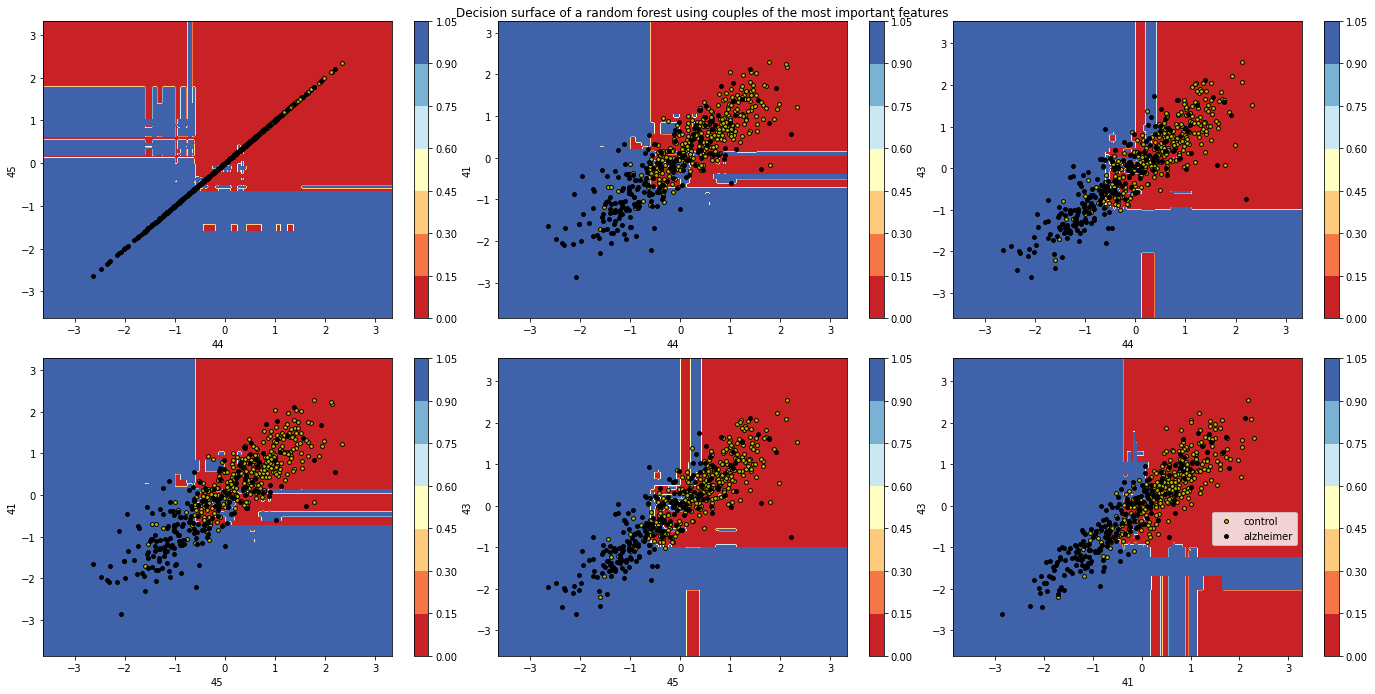

In [0]:
plt.figure(figsize=(20,10))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.colorbar(cs)



    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "yk"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question:** Which is the best couple of features ?

---
__Réponse :__
Le meilleur coupls de features est 45/41. En effet, il semble que c'est le a ou le moins d'alzhameir sont non détectés et là ou les données de contrôles et d'alzheimer sont le plus distinctes.

---

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs.
**Question:** What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 68


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Best Score: 0.8338278145695364
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 20}
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.119229)
2. feature 0 representing Left Hippocampus                       (0.104978)
3. feature 1 representing Right Hippocampus                      (0.062915)
4. feature 46 representing Left Lateral Temporal Ventricle        (0.052948)
5. feature 2 representing Left Amygdala                          (0.051951)
6. feature 12 representing Left Inferior Middle Temporal Gyri     (0.039105)
7. feature 30 representing Left Posterior Temporal Lobe           (0.029667)
8. feature 47 representing Right Lateral Temporal Ventricle       (0.027848)
9. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.025482)
10. feature 45 representing Right Corpus Callosum                  (0.024926)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


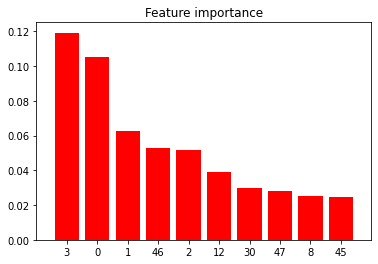

In [0]:
#Using HAMMERS
X=T1HAMMERS
labels=ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))

#Scale data
scaler = StandardScaler()
scaler.fit(X)
X_=scaler.transform(X)

#Meilleurs paramètres

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_, y)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

#Ranking
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_,y)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])

plt.xlim([-1, 10])
plt.show()

---
__Réponse :__
L'atlas Hammers présente des résultats similaires à AAL2, on trouve que l'hippocampus, les amygdales et les Temporals sont importants dans le développement d'alzheimer.

---

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 192


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Best Score: 0.7699602649006623
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 25}
Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.103247)
2. feature 187 representing 188	N_Thalamus-5	189
 (0.041902)
3. feature 172 representing 173	N_Amygdala-1	174
 (0.034871)
4. feature 186 representing 187	N_Thalamus-4	188
 (0.033271)
5. feature 173 representing 174	N_Caudate-1	175
 (0.030068)
6. feature 145 representing 146	S_Parietooccipital-5	147
 (0.025691)
7. feature 189 representing 190	N_Thalamus-7	191
 (0.025114)
8. feature 183 representing 184	N_Thalamus-1	185
 (0.023958)
9. feature 170 representing 171	G_Fusiform-6	172
 (0.023428)
10. feature 181 representing 182	N_Putamen-2	183
 (0.021444)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


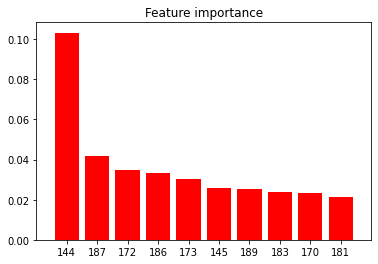

In [0]:
#Using AICHA
X=T1AICHA
labels=ROIlabelsAICHA
atlas='./AtlasAICHA.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))

#Scale data
scaler = StandardScaler()
scaler.fit(X)
X_=scaler.transform(X)

#Meilleurs paramètres

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_, y)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

#Ranking
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_,y)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])

plt.xlim([-1, 10])
plt.show()

---
__Réponse :__
L'atlas Aicha présente des résultats différents des deux autres Atlas, bien que l'amygdale soit présente, de nouvelles régions du cerveau sont porposées comme biomarqueurs, notamment : S_Parietooccipital, N_Caudate, N_Thalamus et G_Fusiform. 

Allons regarder ce que stipulent les papiers de recherche sur ces biomarqueurs.

D'après le papier NeuroImage : 
"Recently, Tang et al. (2015) used shape diﬀeomorphometry of the left and right amygdala, hippocampus, thalamus, caudate, putamen, globus pallidus, and lateral ventricle for prediction of AD conversion using LDA."

Thalamus, putamen et Caudate sont donc des biomarqueurs apropriés, cependant je n'ai pas trouvé d'informatioon sur S_Parietooccipital ou sur G_Fusiform, nous ne pouvons donc pas les considérer comme des biomarqueurs.


---

**Theoretical Questions**

**Question:** Please answer the two questions at slide 28 and 31 writing here the computations.

In [0]:
#Definition des fonctions d'impureté
def H_ent(p):
  if p==1 or p==0:
    return 0
  return -p*np.log(p)-(1-p)*np.log(1-p)

def H_gini(p):
  return 2*p*(1-p)

Tree1= {'Ndroite/N': 1/2, #Proportion des données à droite de la racine
        'Ngauche/N': 1/2, #Proportion des données à gauche de la racine
        'Pdroite': 1/4,   #Porportion d'erreurs dans le noeud dorit
        'Pgauche': 1/4,   #Porportion d'erreurs dans le noeud gauche
        }
Tree2= {'Ndroite/N': 3/4, #Proportion des données à droite de la racine
        'Ngauche/N': 1/4, #Proportion des données à gauche de la racine
        'Pdroite': 1/3,   #Porportion d'erreurs dans le noeud dorit
        'Pgauche': 0,     #Porportion d'erreurs dans le noeud gauche
        }

def L(h,tree):
  if h==0:
    return tree['Ndroite/N']*H_ent(tree['Pdroite'])+tree['Ngauche/N']*H_ent(tree['Pgauche'])
  else:
    return tree['Ndroite/N']*H_gini(tree['Pdroite'])+tree['Ngauche/N']*H_gini(tree['Pgauche'])

L_ent_1=L(0,Tree1)
L_ent_2=L(0,Tree2)

print("The costs with entropy are", L_ent_1, "for the first tree and", L_ent_2, " for the second.")

L_gini_1=L(1,Tree1)
L_gini_2=L(1,Tree2)

print("The costs with gini are", L_gini_1, "for the first tree and", L_gini_2, " for the second.")

The costs with entropy are 0.5623351446188083 for the first tree and 0.4773856262211096  for the second.
The costs with gini are 0.375 for the first tree and 0.33333333333333337  for the second.


---
__Réponse :__
Pour les deux fonctions d'impureté, entropie et gini, la meilleure distribution est la première.

---